In [ ]:
from tensorflow import keras
keras.__version__

'2.4.0'

**생성자 정의**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))

# 판별자는 일반 컨브넷처럼 설계하지만 생성자는 컨브넷을 뒤집은 형태로 설계. 
# 입력을 16 × 16 크기의 128개 채널을 가진 특성 맵으로 변환
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x) # GAN에서는 LeakyReLu를 사용. LeakyReLu는 RelU와 비슷하지만 음수의 활성화 값을 허용하기 떄문에 희소가 완화됨.
x = layers.Reshape((16, 16, 128))(x)

# 합성곱 층을 추가
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# 32 × 32 크기로 업샘플링
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

# 합성곱 층을 더 추가
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# 32 × 32 크기의 1개 채널을 가진 특성 맵을 생성. 결국 생성되는 이미지는 판별자의 컨브넷의 input과 같아야함.
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense (Dense)                (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 256)       104883

**판별자 정의**

In [ ]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)
# 드롭아웃이 있어야 노이즈 감쇠 가능성이 높아짐
x = layers.Dropout(0.4)(x)

# 분류 층
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

# 옵티마이저에서 (값을 지정하여) 그래디언트 클리핑을 사용
# 안정된 훈련을 위해서 학습률 감쇠를 사용
discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 6, 6, 128)         0   

**생성자와 판별자를 연결하여 GAN 설정**

In [ ]:
# 판별자의 가중치가 훈련되지 않도록 동결
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

**DCGAN 훈련**

In [ ]:
!mkdir gan_images

In [ ]:
import os
from tensorflow.keras.preprocessing import image

# CIFAR10 데이터를 로드
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

# 개구리 이미지를 선택(클래스 6)
x_train = x_train[y_train.flatten() == 6]

# 데이터를 정규화
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

iterations = 10000
batch_size = 20
save_dir = './gan_images'

# 훈련 반복 시작
start = 0
for step in range(iterations):
    # 잠재 공간에서 무작위로 포인트를 샘플링
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # 가짜 이미지를 디코딩
    generated_images = generator.predict(random_latent_vectors)

    # 진짜 이미지와 연결
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])

    # 진짜와 가짜 이미지를 구분하여 레이블을 합침
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    # 레이블에 랜덤 노이즈를 추가. very important
    labels += 0.05 * np.random.random(labels.shape)

    # discriminator를 훈련
    d_loss = discriminator.train_on_batch(combined_images, labels)

    # 잠재 공간에서 무작위로 포인트를 샘플링
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # 모두 “진짜 이미지"라고 레이블을 생성
    misleading_targets = np.zeros((batch_size, 1))

    # generator를 훈련(gan 모델에서 discriminator의 가중치는 동결)
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
      start = 0

    # 중간 중간 저장하고 그래프를 그리기
    if step % 100 == 0:
        # 모델 가중치를 저장
        gan.save_weights('gan.h5')

        # 측정 지표를 출력
        print('스텝 %s에서 판별자 손실: %s' % (step, d_loss))
        print('스텝 %s에서 적대적 손실: %s' % (step, a_loss))

        # 생성된 이미지 하나를 저장
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))

        # 비교를 위해 진짜 이미지 하나를 저장
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

170500096/170498071 [==============================] - 2s 0us/step
스텝 0에서 판별자 손실: 0.6925445795059204
스텝 0에서 적대적 손실: 0.6584464311599731
스텝 100에서 판별자 손실: 0.683772087097168
스텝 100에서 적대적 손실: 0.7948927879333496
스텝 200에서 판별자 손실: 0.6857593655586243
스텝 200에서 적대적 손실: 0.7948493957519531
스텝 300에서 판별자 손실: 0.7006310820579529
스텝 300에서 적대적 손실: 0.7416054010391235
스텝 400에서 판별자 손실: 0.685926616191864
스텝 400에서 적대적 손실: 0.7787451148033142
스텝 500에서 판별자 손실: 0.6977096796035767
스텝 500에서 적대적 손실: 0.7384707927703857
스텝 600에서 판별자 손실: 0.695414662361145
스텝 600에서 적대적 손실: 0.7711275815963745
스텝 700에서 판별자 손실: 0.6917566061019897
스텝 700에서 적대적 손실: 0.7649557590484619
스텝 800에서 판별자 손실: 0.6859259605407715
스텝 800에서 적대적 손실: 0.7228334546089172
스텝 900에서 판별자 손실: 0.6785033941268921
스텝 900에서 적대적 손실: 0.7652843594551086
스텝 1000에서 판별자 손실: 0.6862468123435974
스텝 1000에서 적대적 손실: 0.7432540655136108
스텝 1100에서 판별자 손실: 0.7021738290786743
스텝 1100에서 적대적 손실: 0.75157231092453
스텝 1200에서 판별자 손실: 0.6841418743133545
스텝 1200에서 적대적 손실: 0.8300576210021973


In [ ]:
import matplotlib.pyplot as plt

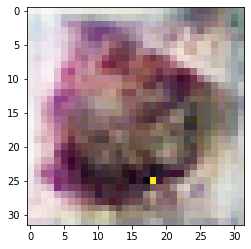

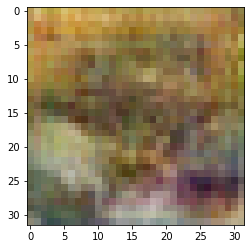

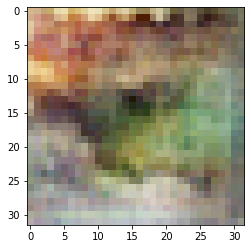

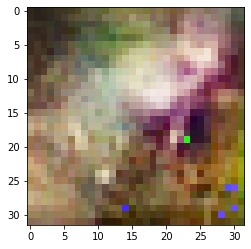

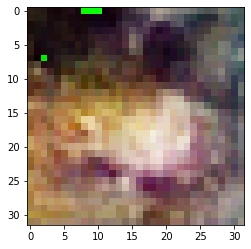

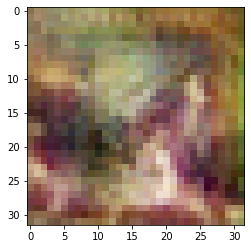

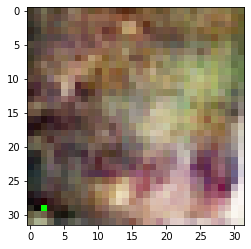

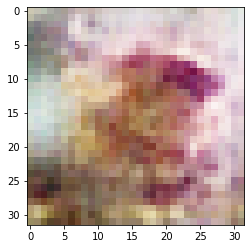

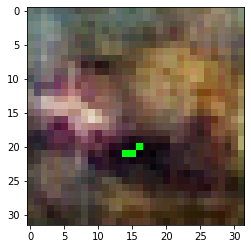

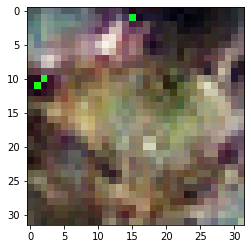

In [ ]:
# 잠재 공간에서 랜덤한 포인트를 샘플링
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# 가짜 이미지로 디코딩
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()